In [1]:
import os
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm
import itertools
import concurrent.futures
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import random
import matplotlib.colors as mcolors

**Database for muxing patterns**

In [3]:
#mux_patterns = {}
mux_patterns['flower_7'] = np.load('7ch_mux.npy')
mux_patterns['flower_3'] = np.load('3ch_mux.npy')
mux_patterns['flower_7_mod'] = np.load('7ch_mux_mod_single_pmt.npy')
mux_patterns['flower_3_mod'] = np.load('3ch_mux_mod_single_pmt.npy')

In [4]:
ch3_mux = np.load('3ch_mux.npy')
ch7_mux = np.load('7ch_mux.npy')
ch3_mux_mod = np.load('3ch_mux_mod_single_pmt.npy')
ch7_mux_mod = np.load('7ch_mux_mod_single_pmt.npy')

**Find neighbouring PMTs & make groups**

In [3]:
adjacent = np.load('pmt_adjacent.npy')   #GET FILE
"""
Shape: (253, 6)
Array containing all 6 neighbouring PMTs for each of the 253 top PMTs
example: [[ 1  7  8 -1 -1 -1], [ 0  2  8  9 -1 -1]] first two PMTs
entry [-1] if neighbouring PMT would be outside of setup
"""

# find PMTs within certain radius of event/thing/other pmt/group
def pmts_adjacent_to_thing(thing, radius, exclude_self=True):
    """
    Which PMTs are adjacent to the given thing?
    """
    adj = set(thing)   # set containing PMTs from "thing"
    for _ in range(radius):   # adjacency "hops", 1 means direct neighbours
        new_adj = set()   # empty set to initialize
        for ch in adj:   # loop over PMTs in set adj
            new_adj |= set(adjacent[ch])   # add PMT to new_adj if not already there
        adj |= new_adj-set([-1])   # include new_adj in adj, exclude placeholders [-1]
    if exclude_self:
        adj -= set(thing)   # remove original PMTs in thing from adj
    return adj

def groups_adjacent_to_pmt(pmt, groups, radius):
    """
    What groups are adjacent to this PMT?
    :param groups: current groups of assigned PMTs
    :param pmt: the PMT number you're looking to assign
    :param radius: how many PMTs away to consider "adjacent"
    """
    adj_channels = pmts_adjacent_to_thing([pmt], radius)   # call function defined previously, returns set of PMTs within specified radius
    # find what groups these PMTs belong to
    adj_groups = set()   # empty set to initialize
    for ch in adj_channels:   #loop through adjacent channels
        for i,group in enumerate(groups):
            if ch in group: # this channel has already been assigned
                adj_groups.add(i)
    return adj_groups   # return set of indices of groups adjacent to given PMT


def groups_adj_to_group(group, groups, radius):   #basically same as above, this time for groups
    """
    Which groups are adjacent to the given group?
    :returns: list of indexes of groups
    """
    adj_to_this_group = pmts_adjacent_to_thing(group, radius)   # call function defined previously
    results = set()   # empty set to initialize
    for pmt in adj_to_this_group:
        for i,other_group in enumerate(groups):
            if pmt in other_group:
                results.add(i)
    return results

def make_group(overlap_range=None, to_assign=None, max_group_size=None, name=None):
    # initialize groups
    groups = []   
    group_by='set'   # indicate grouping method
    # loop through PMTs to assign
    for j,phys_ch in enumerate(to_assign):
        #Determine adjacent groups
        if group_by == 'set':   # find which groups are adajcent to PMT
            adj_groups = groups_adjacent_to_pmt(phys_ch, groups, overlap_range)
        elif group_by == 'dist':
            pass
        else:
            raise ValueError('Invalid value for group_by')
        # find potential groups
        potential_groups = []   # groups current PMT could be added to
        for i,group in enumerate(groups):
            if max_group_size and len(group) >= max_group_size:
                continue   # skip group if already full
            if i in adj_groups:
                continue   # skip if group_i is adjacent to this PMT
            g = groups_adj_to_group(group, groups, 1)
            if adj_groups & g:
                continue   # skip if group_i is already adjacent to another group
            potential_groups.append(i)
        #Assign PMT to group    
        if len(potential_groups):   # multiple possible groups, pick the smallest
            min_len, min_i = 253, -1
            for group_i in potential_groups:
                # add this channel to the smallest existing group
                if (l := len(groups[group_i])) < min_len:
                    min_len = l
                    min_i = group_i
            groups[min_i].append(phys_ch)
        else: # no potential groups, make a new one
            groups.append([phys_ch])
    # Sort and format groups        
    for g in groups:
        g.sort()   # sort PMTs within group in ascending order
    #groups.sort(key=lambda g:g[0])   # sort groups based on first element of each group
    g = np.zeros((len(groups), max(len(g) for g in groups)), dtype=np.int16)   # new empty array with dimensions "number of groups" x "length of largest group"
    for i,row in enumerate(groups):
        l = len(row)   # length of current group
        g[i][:l] = row   # fills first l elements of i-th row of g with elements of current group 
        g[i][l:] = -1   # fills remaining elements with -1
    if name is not None:
        return name, g
    return g

**Ungrouped**

In [4]:
# Ungrouped
ungrouped_mapping = np.array([[i] for i in range(253)], dtype=int)

# Save with key "ungrouped"
#np.savez("mux_patterns_ungrouped.npz", ungrouped=ungrouped_mapping)

print("Ungrouped mux pattern saved to mux_patterns_ungrouped.npz with key 'ungrouped'.")

Ungrouped mux pattern saved to mux_patterns_ungrouped.npz with key 'ungrouped'.


**Make random grouping**

In [38]:
mux_patterns = {}

In [39]:
# true random, all groups same size, last group gets rest

for n in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    n_trials = 100
    group_size = n
    n_groups = int(np.ceil(253 / group_size))
    n_str = f"{n:02d}"
    for t in range(n_trials):
        t_str = f"{t:02d}"
        # Step 1: Shuffle PMT indices
        x = np.arange(253, dtype=np.int16)
        np.random.shuffle(x)
        # Step 2: Pad with -1
        total_size = n_groups * group_size
        padding_needed = total_size - len(x)
        padded = np.concatenate([x, np.full(padding_needed, -1, dtype=np.int16)])
        # Step 3: Reshape into groups
        mux_patterns[f'rand_{n_str}_{t_str}'] = padded.reshape((-1, group_size))


In [42]:
print(mux_patterns.keys())

dict_keys(['rand_02_00', 'rand_02_01', 'rand_02_02', 'rand_02_03', 'rand_02_04', 'rand_02_05', 'rand_02_06', 'rand_02_07', 'rand_02_08', 'rand_02_09', 'rand_02_10', 'rand_02_11', 'rand_02_12', 'rand_02_13', 'rand_02_14', 'rand_02_15', 'rand_02_16', 'rand_02_17', 'rand_02_18', 'rand_02_19', 'rand_02_20', 'rand_02_21', 'rand_02_22', 'rand_02_23', 'rand_02_24', 'rand_02_25', 'rand_02_26', 'rand_02_27', 'rand_02_28', 'rand_02_29', 'rand_02_30', 'rand_02_31', 'rand_02_32', 'rand_02_33', 'rand_02_34', 'rand_02_35', 'rand_02_36', 'rand_02_37', 'rand_02_38', 'rand_02_39', 'rand_02_40', 'rand_02_41', 'rand_02_42', 'rand_02_43', 'rand_02_44', 'rand_02_45', 'rand_02_46', 'rand_02_47', 'rand_02_48', 'rand_02_49', 'rand_02_50', 'rand_02_51', 'rand_02_52', 'rand_02_53', 'rand_02_54', 'rand_02_55', 'rand_02_56', 'rand_02_57', 'rand_02_58', 'rand_02_59', 'rand_02_60', 'rand_02_61', 'rand_02_62', 'rand_02_63', 'rand_02_64', 'rand_02_65', 'rand_02_66', 'rand_02_67', 'rand_02_68', 'rand_02_69', 'rand_02_

**Make deterministic grouping**

In [24]:
# deterministic, not true random

tasks = []
for max_group_size in tqdm([2,3,4,5,6,7,8,9,10], desc='Group size'):
#for max_group_size in tqdm([3], desc='Group size'):
    mgs = str(max_group_size)
    for overlap_range in tqdm([1,2,3,4,5], desc='Overlap range', leave=False):
        rg = str(overlap_range)
        #for trial in tqdm(253 if deterministic else 100, desc='Trial', leave=False):
        #for trial in tqdm(range(10), desc='Trial', leave=False):
        for trial in tqdm([0,20,72,98,122,142,163,203,225,240], desc='Trial', leave=False):
            t = f'{trial:03d}'
            #for step_by in range(3):
            for step_by in [1,2,3]:
                to_assign = np.zeros(253, dtype=np.int16)
                to_assign[0] = trial
                for i in range(1,253):
                    to_assign[i] = (to_assign[i-1]+step_by)%253
                tasks.append((overlap_range, to_assign, max_group_size, f'det_{mgs}_{rg}_{step_by}_{t}'))
                arr = make_group(overlap_range=overlap_range, to_assign=to_assign, max_group_size=max_group_size)
                mux_patterns_new[f'det_{mgs}_{rg}_{step_by}_{t}'] = arr

Overlap range:   0%|          | 0/5 [00:00<?, ?it/s]

Trial:   0%|          | 0/10 [00:00<?, ?it/s]

Trial:  10%|█         | 1/10 [00:00<00:02,  4.27it/s]

Trial:  20%|██        | 2/10 [00:00<00:01,  4.44it/s]

Trial:  30%|███       | 3/10 [00:00<00:01,  4.20it/s]

Trial:  40%|████      | 4/10 [00:00<00:01,  4.14it/s]

Trial:  50%|█████     | 5/10 [00:01<00:01,  4.01it/s]

Trial:  60%|██████    | 6/10 [00:01<00:00,  4.01it/s]

Trial:  70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

Trial:  80%|████████  | 8/10 [00:01<00:00,  3.93it/s]

Trial:  90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

Trial: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                                                      
Overlap range:  20%|██        | 1/5 [00:02<00:09,  2.48s/it]

Trial:   0%|          | 0/10 [00:00<?, ?it/s]

Trial:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Trial:  20%|██        | 2/10 [00:00<00:03,  2.05it/s]

Trial:  30%|███       | 3/10 [00:01<00:03,  2.05it/s]

Trial:  40%|████   

**Some analysis**

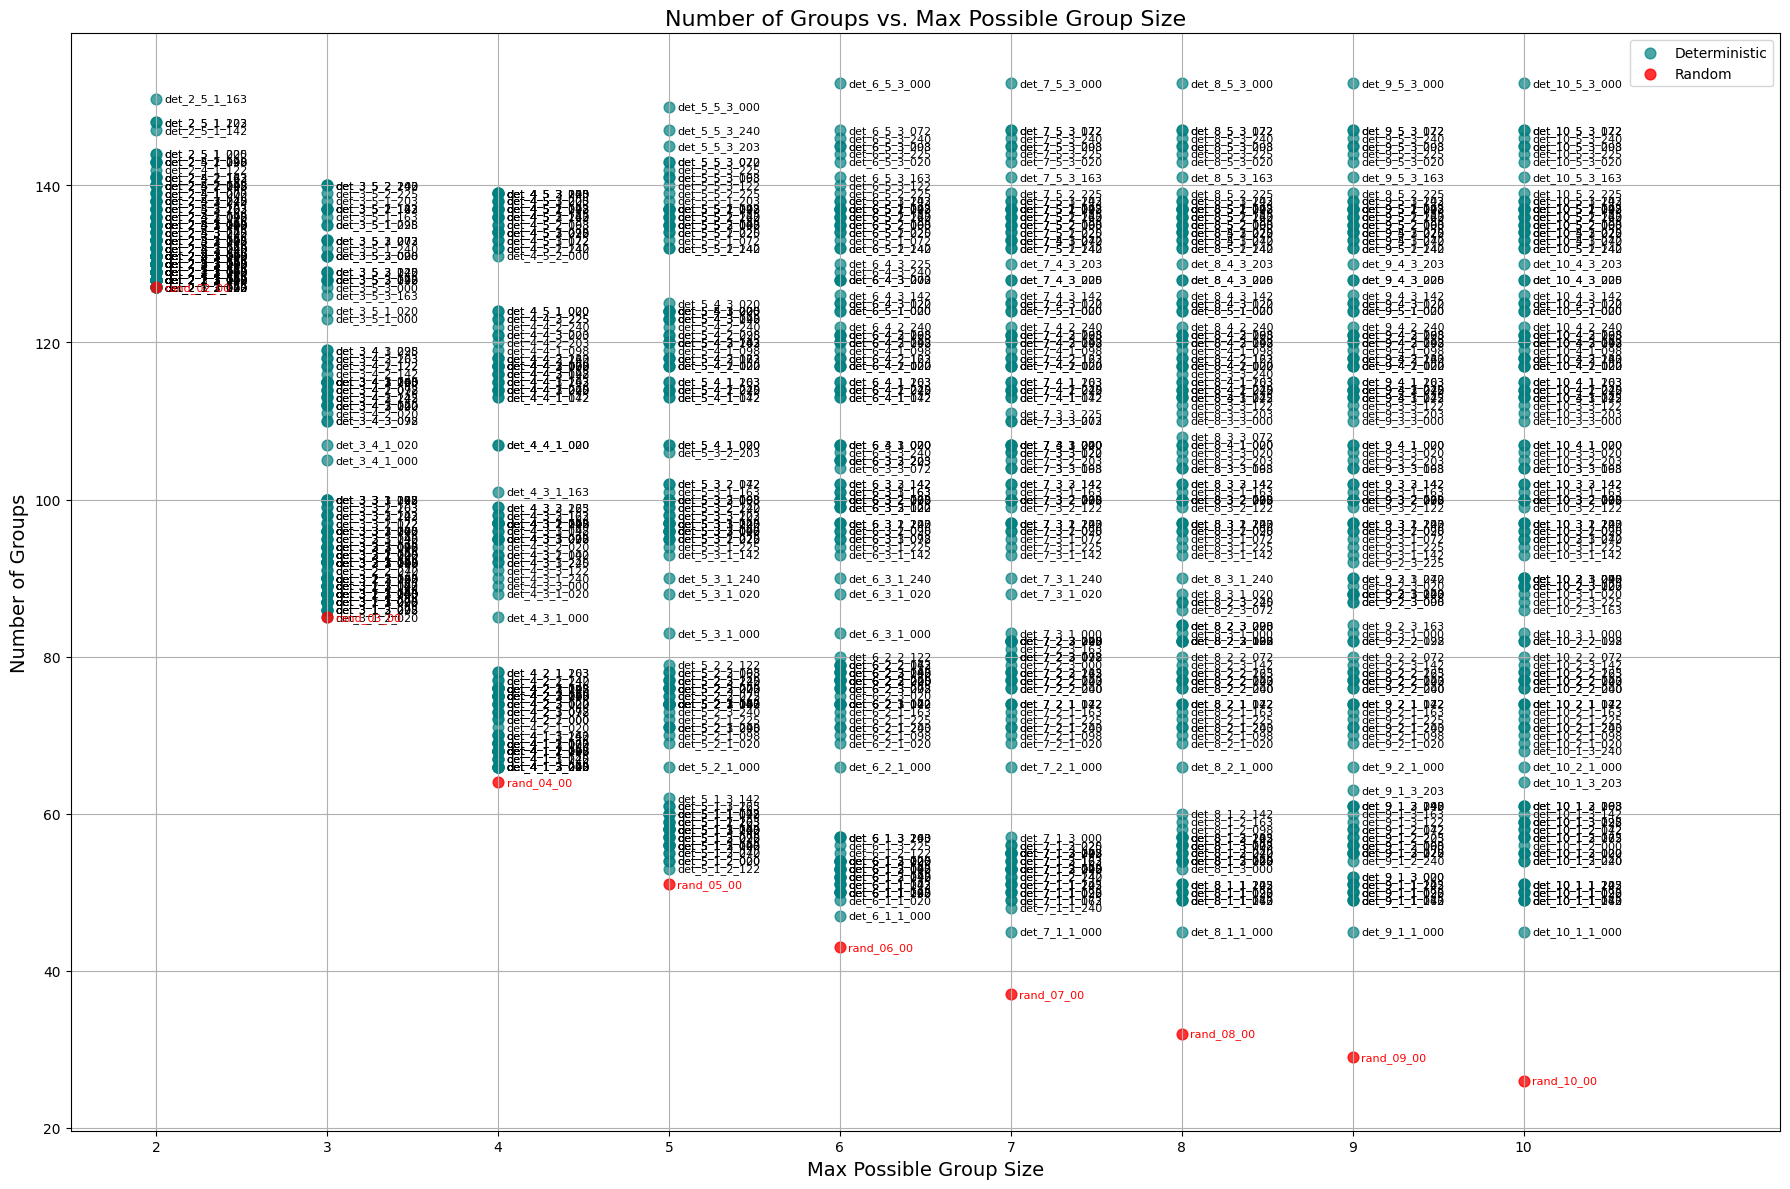

In [29]:
import matplotlib.pyplot as plt

patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# Prepare data for mux_patterns_new (teal points)
x_new = []
y_new = []
labels_new = []

for key, value in patterns.items():
    if key.startswith("det"):
        group_size = int(key.split('_')[1])
        x_new.append(group_size)
        y_new.append(value.shape[0])
        labels_new.append(key)

# Prepare data for mux_patterns entries ending in "_00" (red points)
x_det = []
y_det = []
labels_det = []

for key, value in patterns.items():
    if key.endswith("_00"):
        group_size = int(key.split('_')[1])
        x_det.append(group_size)
        y_det.append(value.shape[0])
        labels_det.append(key)

# Plotting
plt.figure(figsize=(18, 12))

# Plot mux_patterns_new (teal)
plt.scatter(x_new, y_new, s=60, color='teal', alpha=0.7, label='Deterministic')
for i in range(len(x_new)):
    plt.text(x_new[i] + 0.05, y_new[i], labels_new[i], fontsize=8, ha='left', va='center', color='k')

# Plot mux_patterns (red, filtered)
plt.scatter(x_det, y_det, s=60, color='red', alpha=0.8, label='Random')
for i in range(len(x_det)):
    plt.text(x_det[i] + 0.05, y_det[i], labels_det[i], fontsize=8, ha='left', va='center', color='red')

plt.xlabel("Max Possible Group Size", fontsize=14)
plt.ylabel("Number of Groups", fontsize=14)
plt.title("Number of Groups vs. Max Possible Group Size", fontsize=16)
plt.grid(True)
plt.xlim(1.5, 11.5)
plt.xticks(sorted(set(x_new + x_det)))
plt.legend(loc='upper right')
plt.tight_layout()
#plt.show()
#plt.savefig("20250513_max_group_size_vs_number_of_groups.png", dpi=300)

In [36]:
patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
patterns.keys()

KeysView(NpzFile 'mux_patterns_all_new.npz' with keys: det_2_1_1_000, det_2_1_2_000, det_2_1_3_000, det_2_1_1_020, det_2_1_2_020...)

In [11]:
all_patterns.keys()

dict_keys(['det_2_1_1_000', 'det_2_1_2_000', 'det_2_1_3_000', 'det_2_1_1_020', 'det_2_1_2_020', 'det_2_1_3_020', 'det_2_1_1_072', 'det_2_1_2_072', 'det_2_1_3_072', 'det_2_1_1_098', 'det_2_1_2_098', 'det_2_1_3_098', 'det_2_1_1_122', 'det_2_1_2_122', 'det_2_1_3_122', 'det_2_1_1_142', 'det_2_1_2_142', 'det_2_1_3_142', 'det_2_1_1_163', 'det_2_1_2_163', 'det_2_1_3_163', 'det_2_1_1_203', 'det_2_1_2_203', 'det_2_1_3_203', 'det_2_1_1_225', 'det_2_1_2_225', 'det_2_1_3_225', 'det_2_1_1_240', 'det_2_1_2_240', 'det_2_1_3_240', 'det_2_2_1_000', 'det_2_2_2_000', 'det_2_2_3_000', 'det_2_2_1_020', 'det_2_2_2_020', 'det_2_2_3_020', 'det_2_2_1_072', 'det_2_2_2_072', 'det_2_2_3_072', 'det_2_2_1_098', 'det_2_2_2_098', 'det_2_2_3_098', 'det_2_2_1_122', 'det_2_2_2_122', 'det_2_2_3_122', 'det_2_2_1_142', 'det_2_2_2_142', 'det_2_2_3_142', 'det_2_2_1_163', 'det_2_2_2_163', 'det_2_2_3_163', 'det_2_2_1_203', 'det_2_2_2_203', 'det_2_2_3_203', 'det_2_2_1_225', 'det_2_2_2_225', 'det_2_2_3_225', 'det_2_2_1_240', 'de

**Manually create groupings**

In [3]:
mux_pattern_adj_manual = {}

In [32]:
# Numbering not in python index syntax
mux_pattern_adj_manual["adj_2"] = [[1,2],[3,10],[4],[5,6],[7,8],[9,19],[11,12],[13,23],[14],[15],[16,17],[18,30],[20,21],[22,34],[24,25],[26,38],[27],[28],[29,42],[31,32],[33,46],[35,36],[37,50],[39,40],[41,55],[43,44],[45,59],[47,48],[49,63],[51,52],[53,67],[54],[56,57],[58,73],[60,61],[62,77],[64,65],[66,81],[68,69],[70,71],[72,88],[74,75],[76,92],[78,79],[80,96],[82,83],[84,100],[85],[86],[87,103],[89,90],[91,107],[93,94],[95,111],[97,98],[99,115],[101,102],[104,105],[106,122],[108,109],[110,126],[112,113],[114,130],[116,117],[118,134],[119,120],[121,137],[123,124],[125,141],[127,128],[129,145],[131,132],[133,149],[135],[136,152],[138,139],[140,156],[142,143],[144,160],[146,147],[148,164],[150,151],[153,154],[155,171],[157,158],[159,175],[161,162],[163,179],[165,166],[167,183],[168],[169],[170,185],[172,173],[174,189],[176,177],[178,193],[180,181],[182,197],[184],[186,187],[188,202],[190,191],[192,206],[194,195],[196,210],[198,199],[200],[201,214],[203,204],[205,218],[207,208],[209,222],[211,212],[213,226],[215,216],[217,229],[219,220],[221,233],[223,224],[225,237],[227],[228],[230,231],[232,242],[234,235],[236,246],[238],[239,240],[241,248],[243,244],[245,252],[247],[249,250],[251],[253]]
mux_pattern_adj_manual["adj_2_rose"] = [[1,2],[3,4],[5,6],[8,9],[10,11],[12,13],[14,15],[19,20],[21,22],[23,24],[32,33],[34,35],[36,37],[46,47],[48,49],[61,62],[63,64],[77,78],[94,95],[27,40],[54,69],[85,102],[26,39],[53,68],[84,101],[118,135],[25,38],[52,67],[83,100],[117,134],[51,66],[82,99],[116,133],[50,65],[81,98],[115,132],[80,97],[114,131],[79,96],[113,130],[112,129],[111,128],[168,184],[199,213],[226,238],[151,167],[183,198],[212,225],[237,247],[150,166],[182,197],[211,224],[149,165],[181,196],[210,223],[148,164],[180,195],[147,163],[179,194],[146,162],[145,161],[253,252],[251,250],[249,248],[246,245],[244,243],[242,241],[240,239],[236,235],[234,233],[232,231],[230,229],[222,221],[220,219],[218,217],[209,208],[207,206],[205,204],[193,192],[191,190],[178,177],[176,175],[160,159],[144,143],[152,169],[185,200],[214,227],[119,136],[153,170],[186,201],[215,228],[137,154],[171,187],[202,216],[121,138],[155,172],[188,203],[139,156],[173,189],[123,140],[157,174],[141,158],[125,142],[16,28],[41,55],[70,86],[7,17],[29,42],[56,71],[87,103],[18,30],[43,57],[72,88],[104,120],[31,44],[58,73],[89,105],[45,59],[74,90],[106,122],[60,75],[91,107],[76,92],[108,124],[93,109],[110,126],[127]]
mux_pattern_adj_manual["adj_4"] = [[1],[2,3],[4,5],[6],[7,8,17,18],[9,10,19,20],[11,12,21,22],[13,14,23,24],[15,25,26],[16],[27],[28,41],[29,30,42,43],[31,32,44,45],[33,34,46,47],[35,36,48,49],[37,38,50,51],[39,40,52,53],[54],[55,70],[56,57,71,72],[58,59,73,74],[60,61,75,76],[62,63,77,78],[64,65,79,80],[66,67,81,82],[68,69,83,84],[85],[86],[87,88,103,104],[89,90,105,106],[91,92,107,108],[93,94,109,110],[95,96,111,112],[97,98,113,114],[99,100,115,116],[101,102,117,118],[119,120,136],[121,122,137,138],[123,124,139,140],[125,126,141,142],[127,128,143,144],[129,130,145,146],[131,132,147,148],[133,134,149,150],[135,151],[152],[153,154,169,170],[155,156,171,172],[157,158,173,174],[159,160,175,176],[161,162,177,178],[163,164,179,180],[165,166,181,182],[167,168,183,184],[185],[186,187,200,201],[188,189,202,203],[190,191,204,205],[192,193,206,207],[194,195,208,209],[196,197,210,211],[198,199,212,213],[214],[215,216,227,228],[217,218,229,230],[219,220,231,232],[221,222,233,234],[223,224,235,236],[225,226,237,238],[239,240],[241,242,248,249],[243,244,250,251],[245,246,252,253],[247]]
mux_pattern_adj_manual["adj_5_bow"] = [[1,2,3,10],[4],[5,12,13,14,24],[6,15],[7,8,9,19],[16,17,18,30],[28,29,42],[41,55],[11,21,22,23,35],[20,32,33,34,47],[31,44,45,46,60],[43,57,58,59,74],[56,71,72,73,89],[70,86,87,88,104],[103,119],[26,27,40],[25,37,38,39,52],[36,49,50,51,65],[48,62,63,64,79],[61,76,77,78,94],[75,91,92,93,109],[90,106,107,108,124],[105,121,122,123,139],[120,136,137,138,154],[152,153,169],[54],[53,67,68,69,84],[66,81,82,83,99],[80,96,97,98,114],[95,111,112,113,129],[110,126,127,128,144],[125,141,142,143,159],[140,156,157,158,174],[155,171,172,173,188],[170,185,186,187,201],[200],[85,101,102],[100,116,117,118,134],[115,131,132,133,149],[130,146,147,148,164],[145,161,162,163,179],[160,176,177,178,193],[175,190,191,192,206],[189,203,204,205,218],[202,215,216,217,229],[214,227,228],[135,151],[150,166,167,168,184],[165,181,182,183,198],[180,195,196,197,211],[194,208,209,210,223],[207,220,221,222,234],[219,231,232,233,243],[230,240,241,242,249],[239,248],[199,213],[212,225,226],[224,236,237,238],[235,245,246,247],[244,251,252,253],[250]]
mux_pattern_adj_manual["adj_5_rose"] = [[1,2,3,9,10],[4,5,11,12],[6,13,14,23,24],[15,25,26],[27,39,40,53,54],[68,69,84,85],[100,101,102,117,118],[134,135,151],[167,168,183,184,199],[198,212,213,226],[211,224,225,237,238],[236,246,247],[244,245,251,252,253],[242,243,249,250],[230,231,240,241,248],[228,229,239],[200,201,214,215,227],[169,170,185,186],[136,137,152,153,154],[103,119,120],[55,70,71,86,87],[28,41,42,56],[16,17,29,30,43],[7,8,18],[19,31,32,44,45],[20,21,22,33,34],[35,48,49,62,63],[46,47,60,61,76],[77,78,93,94,110],[36,37,38,50,51],[52,66,67,82,83],[64,65,79,80,81],[97,98,99,114,115],[95,96,111,112,113],[116,132,133,149,150],[165,166,181,182,197],[130,131,147,148,164],[163,179,180,195,196],[128,129,145,146,162],[144,160,161,176,177],[178,193,194,207,208],[191,192,205,206,219],[209,210,222,223,235],[220,221,232,233,234],[139,140,155,156,157],[141,142,143,158,159],[171,172,187,188,202],[173,174,175,189,190],[203,204,216,217,218],[57,72,73,88,89],[58,59,74,75,91],[90,106,107,123,124],[92,108,109,125,126],[104,105,121,122,138],[127]]
mux_pattern_adj_manual["adj_6_bow"] = [[7,17],[16,28,29,42],[41,55,56,71],[70,86,87,103],[119],[1,2,8,9,10,20],[18,19,30,31,32,45],[43,44,57,58,59,74],[72,73,88,89,90,106],[104,105,120,121,122,138],[136,137,152,153,154,170],[169,185],[3],[6],[4,5,11,12,13,23],[21,22,33,34,35,48],[46,47,60,61,62,77],[75,76,91,92,93,109],[107,108,123,124,125,141],[139,140,155,156,157,173],[171,172,186,187,188,202],[200,201,214,215,227],[14,15,26],[24,25,36,37,38,51],[49,50,63,64,65,80],[78,79,94,95,96,112],[110,111,126,127,128,144],[142,143,158,159,160,176],[174,175,189,190,191,205],[203,204,216,217,218,230],[228,229,239,240],[27],[39,40,52,53,54,68],[66,67,81,82,83,99],[97,98,113,114,115,131],[129,130,145,146,147,163],[161,162,177,178,179,194],[192,193,206,207,208,221],[219,220,231,232,233,243],[241,242,248,249,250],[69],[84,85,100,101,102,118],[116,117,132,133,134,150],[148,149,164,165,166,182],[180,181,195,196,197,211],[209,210,222,223,224,236],[234,235,244,245,246,253],[251,252],[135,151],[167,168,183,184],[198,199,212,213],[225,226,237,238],[247]]
mux_pattern_adj_manual["adj_6_rose"] = [[1,2,9],[3],[4,5,11,12,22],[6,13,14,23,24,36],[10,20,21,33,34,47],[35,48,49,62,63,78],[61,76,77,93,94,110],[7,8,18],[19,31,32,45,46,60],[15,25,26],[37,38,50,51,64,65],[79,80,95,96,111,112],[27,39,40],[52,53,66,67,81,82],[54],[68,69,83,84,85],[97,98,99,113,114,115],[100,101,102,116,117,118],[128,129,130,145,146,147],[131,132,133,148,149,150],[134,135,151],[164,165,166,181,182,183],[167,168,184],[199],[162,163,179,180,195,196],[197,198,212,213,226],[210,211,224,225,237,238],[144,160,161,177,178,193],[194,208,209,222,223,235],[236,246,247],[176,191,192,205,206,219],[218,230,231,240,241,248],[207,220,221,233,234,244],[245,252,253],[232,242,243,249,250],[251],[136,137,138,152,153,154],[139,140,141,155,156,157],[142,143,158,159,174,175],[189,190,203,204,216,217],[228,229,239],[169,170,171,185,186],[172,173,187,188,201,202],[214,215,227],[200],[16,17,29,30,43,44],[58,59,74,75,91,92],[107,108,109,124,125,126],[104,105,106,121,122,123],[103,119,120],[28,41,42,56,57],[71,72,73,88,89,90],[70,86,87],[55],[127]]
mux_pattern_adj_manual["adj_8"] = [[1,2,3,9,10,11],[7,8,17,18,19,30,31,32],[16],[28,29,41,42,43,56,57,58],[55,70,71,86,87,88],[119],[4,5,6,12,13,14,23,24],[20,21,22,33,34,35,47,48],[44,45,46,59,60,61,75,76],[72,73,74,89,90,91,106,107],[103,104,105,120,121,122,137,138],[136,152,153,169],[15,25,26,27,38,39,40],[36,37,49,50,51,64,65,66],[62,63,77,78,79,94,95,96],[92,93,108,109,110,125,126,127],[123,124,139,140,141,156,157,158],[154,155,170,171,172,186,187,188],[185,200,214],[52,53,54,67,68,69,83,84],[80,81,82,97,98,99,114,115],[111,112,113,128,129,130,145,146],[142,143,144,159,160,161,176,177],[173,174,175,189,190,191,204,205],[201,202,203,215,216,217,228,229],[227],[85,102],[100,101,116,117,118,133,134,135],[131,132,147,148,149,164,165,166],[162,163,178,179,180,194,195,196],[192,193,206,207,208,220,221,222],[218,219,230,231,232,241,242,243],[239,240,248],[150,151,167,168,184],[181,182,183,197,198,199,212,213],[209,210,211,223,224,225,236,237],[233,234,235,244,245,246,252,253],[249,250,251],[226,238],[247]]
mux_pattern_adj_manual["adj_9"] = [[1,2,3,9,10,11],[4,5,6,12,13,14],[15],[7,8],[16,28,29,41,42,43],[17,18,19,30,31,32,44,45,46],[20,21,22,33,34,35,47,48,49],[23,24,25,36,37,38,50,51,52],[26,27,39,40,53,54],[55,70,71,86,87,88],[56,57,58,72,73,74,89,90,91],[59,60,61,75,76,77,92,93,94],[62,63,64,78,79,80,95,96,97],[65,66,67,81,82,83,98,99,100],[68,69,84,85,101,102],[119,136],[103,104,105,120,121,122,137,138,139],[106,107,108,123,124,125,140,141,142],[109,110,111,126,127,128,143,144,145],[112,113,114,129,130,131,146,147,148],[115,116,117,132,133,134,149,150,151],[118,135],[152,153,169,170,185,186],[154,155,156,171,172,173,187,188,189],[157,158,159,174,175,176,190,191,192],[160,161,162,177,178,179,193,194,195],[163,164,165,180,181,182,196,197,198],[166,167,168,183,184,199],[200,201,214,215,227,228],[202,203,204,216,217,218,229,230,231],[205,206,207,219,220,221,232,233,234],[208,209,210,222,223,224,235,236,237],[211,212,213,225,226,238],[239],[240,241,242,248,249,250],[243,244,245,251,252,253],[246,247]]
mux_pattern_adj_manual["adj_10"] = [[7],[1,2,3],[16,17,28,29,30,41,42,43],[8,9,10,18,19,20,21,31,32,33],[4,5,6,11,12,13,14,22,23,24],[15],[86],[55,56,57,70,71,72,73,87,88,89],[44,45,46,58,59,60,61,74,75,76],[34,35,36,47,48,49,50,62,63,64],[25,26,27,37,38,39,40,51,52,53],[103,104,105,119,120,121,122,136,137,138],[90,91,92,106,107,108,109,123,124,125],[77,78,79,93,94,95,96,110,111,112],[65,66,67,80,81,82,83,97,98,99],[54,68,69,84,85],[152,153,154,169,170,171,185,186],[139,140,141,155,156,157,158,172,173,174],[126,127,128,142,143,144,145,159,160,161],[113,114,115,129,130,131,132,146,147,148],[100,101,102,116,117,118,133,134,135],[200,214],[187,188,189,201,202,203,204,215,216,217],[175,176,177,190,191,192,193,205,206,207],[162,163,164,178,179,180,181,194,195,196],[149,150,151,165,166,167,168,182,183,184],[227,228,229,239,240],[218,219,220,230,231,232,233,241,242,243],[208,209,210,221,222,223,224,234,235,236],[197,198,199,211,212,213,225,226],[248,249,250],[244,245,246,251,252,253],[237,238,247]]
mux_pattern_adj_manual["adj_football_small"] = [[7,8,17,18],[3,4,10,11,12,21,22],[14,15,25,26],[41,42,55,56,57,71,72],[45,46,59,60,61,75,76],[49,50,63,64,65,79,80],[53,54,67,68,69,83,84],[103,119,120,136],[106,107,122,123,124,139,140],[110,111,126,127,128,143,144],[114,115,130,131,132,147,148],[118,134,135,151],[170,171,185,186,187,200,201],[174,175,189,190,191,204,205],[178,179,193,194,195,208,209],[182,183,197,198,199,212,213],[228,229,239,240],[232,233,242,243,244,250,251],[236,237,246,247],[1,2],[5,6],[9],[13],[16,28],[29],[30,43,44],[31],[19,20,32],[33],[34,47,48],[35],[23,24,36],[37],[38,51,52],[39],[27,40],[58],[62],[66],[70,86],[87],[88,104,105],[89],[73,74,90],[91],[92,108,109],[93],[77,78,94],[95],[96,112,113],[97],[81,82,98],[99],[100,116,117],[101],[85,102],[121],[125],[129],[133],[152,169],[153],[137,138,154],[155],[156,172,173],[157],[141,142,158],[159],[160,176,177],[161],[145,146,162],[163],[164,180,181],[165],[149,150,166],[167],[168,184],[188],[192],[196],[214,227],[215],[202,203,216],[217],[218,230,231],[219],[206,207,220],[221],[222,234,235],[223],[210,211,224],[225],[226,238],[241],[245],[248,249],[252,253]]
mux_pattern_adj_manual["adj_football_large"] = [[1,7,8,16,17,18],[6,14,15,25,26,27],[10,11,12,20,21,22,23,32,33,34,35,36,46,47,48,49,61,62,63],[42,43,44,56,57,58,59,71,72,73,74,75,88,89,90,91,105,106,107],[86,103,119,120,136,152],[51,52,53,65,66,67,68,80,81,82,83,84,97,98,99,100,114,115,116],[93,94,95,109,110,111,112,125,126,127,128,129,142,143,144,145,159,160,161],[138,139,140,154,155,156,157,170,171,172,173,174,186,187,188,189,201,202,203],[102,118,134,135,151,168],[147,148,149,163,164,165,166,179,180,181,182,183,195,196,197,198,210,211,212],[191,192,193,205,206,207,208,218,219,220,221,222,231,232,233,234,242,243,244],[227,228,229,239,240,248],[236,237,238,246,247,253],[2],[3,4],[5],[13,24],[37],[50,64],[79],[77,78],[76],[45,60],[31],[9,19],[38,39],[40],[54,69],[85],[101,117],[133],[131,132],[130],[96,113],[150,167],[184],[199,213],[226],[224,225],[223],[194,209],[178],[146,162],[235,245],[252],[250,251],[249],[230,241],[217],[190,204],[175],[176,177],[215,216],[214],[185,200],[169],[137,153],[121],[122,123],[124],[141,158],[87,104],[70],[41,55],[28],[29,30],[92,108]]
mux_pattern_adj_manual["adj_mosaik"] = [[10,11,12,20,21,22,23,32,33,34,35,36,46,47,48,49,61,62,63],[89,90,91,105,106,107,108,121,122,123,124,125,138,139,140,141,155,156,157],[97,98,99,113,114,115,116,129,130,131,132,133,146,147,148,149,163,164,165],[191,192,193,205,206,207,208,218,219,220,221,222,231,232,233,234,242,243,244],[29,30,42,43,44,57,58],[38,39,51,52,53,66,67],[110,111,126,127,128,143,144],[187,188,201,202,203,215,216],[196,197,210,211,212,224,225],[1,8,9],[2,3],[4,5],[6,13,14],[7,17],[15,26],[16,28],[18,19,31],[24,25,37],[27,40],[41,55],[45],[50],[54,69],[56,71,72],[59,60,75],[64,65,80],[68,83,84],[70,86],[73,74],[76,92,93],[77,78,94],[79,95,96],[81,82],[85,102],[87,103,104],[88],[109],[112],[100],[101,117,118],[119,120],[134,135],[136,137,153],[142],[145],[150,151,167],[152,169],[154],[158,159,175],[160,176,177],[161,162,178],[166],[168,184],[170,171,186],[172,173],[174,189,190],[179,194,195],[180,181],[182,183,198],[185,200],[199,213],[204],[209],[214,227],[217,229,230],[223,235,236],[226,238],[228,239],[237,247],[240,241,248],[245,246,253],[249,250],[251,252]]



In [26]:
mux_pattern_adj_manual["adj_2"] = [
    [0,1], [2,9], [3], [4,5], [6,7], [8,18], [10,11], [12,22], [13], [14], [15,16], [17,29], [19,20], [21,33], [23,24], [25,37], [26], [27], [28,41], [30,31], [32,45], [34,35], [36,49], [38,39], [40,54], [42,43], [44,58], [46,47], [48,62], [50,51], [52,66], [53], [55,56], [57,72], [59,60], [61,76], [63,64], [65,80], [67,68], [69,70], [71,87], [73,74], [75,91], [77,78], [79,95], [81,82], [83,99], [84], [85], [86,102], [88,89], [90,106], [92,93], [94,110], [96,97], [98,114], [100,101], [103,104], [105,121], [107,108], [109,125], [111,112], [113,129], [115,116], [117,133], [118,119], [120,136], [122,123], [124,140], [126,127], [128,144], [130,131], [132,148], [134], [135,151], [137,138], [139,155], [141,142], [143,159], [145,146], [147,163], [149,150], [152,153], [154,170], [156,157], [158,174], [160,161], [162,178], [164,165], [166,182], [167], [168], [169,184], [171,172], [173,188], [175,176], [177,192], [179,180], [181,196], [183], [185,186], [187,201], [189,190], [191,205], [193,194], [195,209], [197,198], [199], [200,213], [202,203], [204,217], [206,207], [208,221], [210,211], [212,225], [214,215], [216,228], [218,219], [220,232], [222,223], [224,236], [226], [227], [229,230], [231,241], [233,234], [235,245], [237], [238,239], [240,247], [242,243], [244,251], [246], [248,249], [250], [252]]

mux_pattern_adj_manual["adj_2_rose"] = [
    [0, 1], [2, 3], [4, 5], [7, 8], [9, 10], [11, 12], [13, 14], [18, 19], [20, 21], [22, 23], [31, 32], [33, 34], [35, 36], [45, 46], [47, 48], [60, 61], [62, 63], [76, 77], [93, 94], [26, 39], [53, 68], [84, 101], [25, 38], [52, 67], [83, 100], [117, 134], [24, 37], [51, 66], [82, 99], [116, 133], [50, 65], [81, 98], [115, 132], [49, 64], [80, 97], [114, 131], [79, 96], [113, 130], [78, 95], [112, 129], [111, 128], [167, 183], [198, 212], [225, 237], [150, 166], [182, 197], [211, 224], [236, 246], [149, 165], [181, 196], [210, 223], [148, 164], [180, 195], [209, 222], [147, 163], [179, 194], [146, 162], [145, 161], [252, 251], [250, 249], [248, 247], [245, 244], [243, 242], [241, 240], [239, 238], [235, 234], [233, 232], [231, 230], [229, 228], [221, 220], [219, 218], [217, 216], [208, 207], [206, 205], [204, 203], [192, 191], [190, 189], [177, 176], [175, 174], [159, 158], [143, 142], [151, 168], [184, 199], [213, 226], [118, 135], [152, 169], [185, 200], [214, 227], [136, 153], [170, 186], [201, 215], [120, 137], [154, 171], [187, 202], [138, 155], [172, 188], [122, 139], [156, 173], [140, 157], [124, 141], [15, 27], [40, 54], [69, 85], [6, 16], [28, 41], [55, 70], [86, 102], [17, 29], [42, 56], [71, 87], [103, 119], [30, 43], [57, 72], [88, 104], [44, 58], [73, 89], [105, 121], [59, 74], [90, 106], [75, 91], [107, 123], [92, 108], [109, 125], [126]]

mux_pattern_adj_manual["adj_4"] = [
    [0], [1,2], [3,4], [5], [6,7,16,17], [8,9,18,19], [10,11,20,21], [12,13,22,23], [14,24,25], [15], [26], [27,40], [28,29,41,42], [30,31,43,44], [32,33,45,46], [34,35,47,48], [36,37,49,50], [38,39,51,52], [53], [54,69], [55,56,70,71], [57,58,72,73], [59,60,74,75], [61,62,76,77], [63,64,78,79], [65,66,80,81], [67,68,82,83], [84], [85], [86,87,102,103], [88,89,104,105], [90,91,106,107], [92,93,108,109], [94,95,110,111], [96,97,112,113], [98,99,114,115], [100,101,116,117], [118,119,135], [120,121,136,137], [122,123,138,139], [124,125,140,141], [126,127,142,143], [128,129,144,145], [130,131,146,147], [132,133,148,149], [134,150], [151], [152,153,168,169], [154,155,170,171], [156,157,172,173], [158,159,174,175], [160,161,176,177], [162,163,178,179], [164,165,180,181], [166,167,182,183], [184], [185,186,199,200], [187,188,201,202], [189,190,203,204], [191,192,205,206], [193,194,207,208], [195,196,209,210], [197,198,211,212], [213], [214,215,226,227], [216,217,228,229], [218,219,230,231], [220,221,232,233], [222,223,234,235], [224,225,236,237], [238,239], [240,241,247,248], [242,243,249,250], [244,245,251,252], [246]]

mux_pattern_adj_manual["adj_5_bow"] = [
    [0,1,2,9], [3], [4,11,12,13,23], [5,14], [6,7,8,18], [15,16,17,29], [27,28,41], [40,54], [10,20,21,22,34], [19,31,32,33,46], [30,43,44,45,59], [42,56,57,58,73], [55,70,71,72,88], [69,85,86,87,103], [102,118], [25,26,39], [24,36,37,38,51], [35,48,49,50,64], [47,61,62,63,78], [60,75,76,77,93], [74,90,91,92,108], [89,105,106,107,123], [104,120,121,122,138], [119,135,136,137,153], [151,152,168], [53], [52,66,67,68,83], [65,80,81,82,98], [79,95,96,97,113], [94,110,111,112,128], [109,125,126,127,143], [124,140,141,142,158], [139,155,156,157,173], [154,170,171,172,187], [169,184,185,186,200], [199], [84,100,101], [99,115,116,117,133], [114,130,131,132,148], [129,145,146,147,163], [144,160,161,162,178], [159,175,176,177,192], [174,189,190,191,205], [188,202,203,204,217], [201,214,215,216,228], [213,226,227], [134,150], [149,165,166,167,183], [164,180,181,182,197], [179,194,195,196,210], [193,207,208,209,222], [206,219,220,221,233], [218,230,231,232,242], [229,239,240,241,248], [238,247], [198,212], [211,224,225], [223,235,236,237], [234,244,245,246], [243,250,251,252], [249]]

mux_pattern_adj_manual["adj_5_rose"] = [
    [0,1,2,8,9], [3,4,10,11], [5,12,13,22,23], [14,24,25], [26,38,39,52,53], [67,68,83,84], [99,100,101,116,117], [133,134,150], [166,167,182,183,198], [197,211,212,225], [210,223,224,236,237], [235,245,246], [243,244,250,251,252], [241,242,248,249], [229,230,239,240,247], [227,228,238], [199,200,213,214,226], [168,169,184,185], [135,136,151,152,153], [102,118,119], [54,69,70,85,86], [27,40,41,55], [15,16,28,29,42], [6,7,17], [18,30,31,43,44], [19,20,21,32,33], [34,47,48,61,62], [45,46,59,60,75], [76,77,92,93,109], [35,36,37,49,50], [51,65,66,81,82], [63,64,78,79,80], [96,97,98,113,114], [94,95,110,111,112], [115,131,132,148,149], [164,165,180,181,196], [129,130,146,147,163], [162,178,179,194,195], [127,128,144,145,161], [143,159,160,175,176], [177,192,193,206,207], [190,191,204,205,218], [208,209,221,222,234], [219,220,231,232,233], [138,139,154,155,156], [140,141,142,157,158], [170,171,186,187,201], [172,173,174,188,189], [202,203,215,216,217], [56,71,72,87,88], [57,58,73,74,90], [89,105,106,122,123], [91,107,108,124,125], [103,104,120,121,137]]

mux_pattern_adj_manual["adj_6_bow"] = [
    [6,16], [15,27,28,41], [40,54,55,70], [69,85,86,102], [118], [0,1,7,8,9,19], [17,18,29,30,31,44], [42,43,56,57,58,73], [71,72,87,88,89,105], [103,104,119,120,121,137], [135,136,151,152,153,169], [168,184], [2], [5], [3,4,10,11,12,22], [20,21,32,33,34,47], [45,46,59,60,61,76], [74,75,90,91,92,108], [106,107,122,123,124,140], [138,139,154,155,156,172], [170,171,185,186,187,201], [199,200,213,214,226], [13,14,25], [23,24,35,36,37,50], [48,49,62,63,64,79], [77,78,93,94,95,111], [109,110,125,126,127,143], [141,142,157,158,159,175], [173,174,188,189,190,204], [202,203,215,216,217,229], [227,228,238,239], [26], [38,39,51,52,53,67], [65,66,80,81,82,98], [96,97,112,113,114,130], [128,129,144,145,146,162], [160,161,176,177,178,193], [191,192,205,206,207,220], [218,219,230,231,232,242], [240,241,247,248,249], [68], [83,84,99,100,101,117], [115,116,131,132,133,149], [147,148,163,164,165,181], [179,180,194,195,196,210], [208,209,221,222,223,235], [233,234,243,244,245,252], [250,251], [134,150], [166,167,182,183], [197,198,211,212], [224,225,236,237], [246]]

mux_pattern_adj_manual["adj_6_rose"] = [
    [0,1,8], [2], [3,4,10,11,21], [5,12,13,22,23,35], [9,19,20,32,33,46], [34,47,48,61,62,77], [60,75,76,92,93,109], [6,7,17], [14,24,25], [36,37,49,50,63,64], [78,79,94,95,110,111], [26,38,39], [51,52,65,66,80,81], [53], [67,68,82,83,84], [96,97,98,112,113,114], [99,100,101,116,117], [127,128,129,144,155,146], [130,131,132,147,148,149], [133,134,150], [163,164,165,180,181,182], [166,167,183], [198], [161,162,178,179,194,195], [196,197,211,212,225], [209,210,223,224,236,237], [143,159,160,176,177,192], [193,207,208,221,222,234], [235,245,246], [175,190,191,204,205,218], [217,229,230,239,240,247], [206,219,220,232,233,243], [244,251,252], [231,241,242,248,249], [250], [135,136,137,151,152,153], [138,139,140,154,155,156], [141,142,157,158,173,174], [188,189,202,203,215,216], [227,228,238], [168,169,170,184,185], [171,172,186,187,200,201], [213,214,226], [199], [15,16,28,29,42,43], [57,58,73,74,90,91], [106,107,108,123,124,125], [103,104,105,120,121,122], [102,118,119], [27,40,41,55,56], [70,71,72,87,88,89], [69,85,86], [54]]

mux_pattern_adj_manual["adj_8"] = [
    [0,1,2,8,9,10], [6,7,16,17,18,29,30,31], [15], [27,28,40,41,42,55,56,57], [54,69,70,85,86,87], [118], [3,4,5,11,12,13,22,23], [19,20,21,32,33,34,46,47], [43,44,45,58,59,60,74,75], [71,72,73,88,89,90,105,106], [102,103,104,119,120,121,136,137], [135,151,152,168], [14,24,25,26,37,38,39], [35,36,48,49,50,63,64,65], [61,62,76,77,78,93,94,95], [91,92,107,108,109,124,125,126], [122,123,138,139,140,155,156,157], [153,154,169,170,171,185,186,187], [184,199,213], [51,52,53,66,67,68,82,83], [79,80,81,96,97,98,113,114], [110,111,112,127,128,129,144,145], [141,142,143,158,159,160,175,176], [172,173,174,188,189,190,203,204], [200,201,202,214,215,216,227,228], [226], [84,101], [99,100,115,116,117,132,133,134], [130,131,146,147,148,163,164,165], [161,162,177,178,179,193,194,195], [191,192,205,206,207,219,220,221], [217,218,229,230,231,240,241,242], [239,247], [149,150,166,167,183], [180,181,182,196,197,198,211,212], [208,209,210,222,223,224,235,236], [232,233,234,243,244,245,251,252], [248,249,250], [225,237], [246]]

mux_pattern_adj_manual["adj_9"] = [
    [0,1,2,8,9,10], [3,4,5,11,12,13], [14], [6,7], [15,27,28,40,41,42], [16,17,18,29,30,31,43,44,45], [19,20,21,32,33,34,46,47,48], [22,23,24,35,36,37,49,50,51], [25,26,38,39,52,53], [54,69,70,85,86,87], [55,56,57,71,72,73,88,89,90], [58,59,60,74,75,76,91,92,93], [61,62,63,77,78,79,94,95,96], [64,65,66,80,81,82,97,98,99], [67,68,83,84,100,101], [118,135], [102,103,104,119,120,121,136,137,138], [105,106,107,122,123,124,139,140,141], [108,109,110,125,126,127,142,143,144], [111,112,113,128,129,130,145,146,147], [114,115,116,131,132,133,148,149,150], [117,134], [151,152,168,169,184,185], [153,154,155,170,171,172,186,187,188], [156,157,158,173,174,175,189,190,191], [159,160,161,176,177,178,192,193,194], [162,163,164,179,180,181,195,196,197], [165,166,167,182,183,198], [199,200,213,214,226,227], [201,202,203,215,216,217,228,229,230], [204,205,206,218,219,220,231,232,233], [207,208,209,221,222,223,234,235,236], [210,211,212,224,225,237], [238], [239,240,241,247,248,249], [242,243,244,250,251,252], [245,246]]

mux_pattern_adj_manual["adj_10"] = [
    [6], [0,1,2], [15,16,27,28,29,40,41,42], [7,8,9,17,18,19,20,30,31,32], [3,4,5,10,11,12,13,21,22,23], [85], [54,55,56,69,70,71,72,86,87,88], [43,44,45,57,58,59,60,73,74,75], [33,34,35,46,47,48,49,61,62,63], [24,25,26,36,37,38,39,50,51,52], [102,103,104,118,119,120,121,135,136,137], [89,90,91,105,106,107,108,122,123,124], [76,77,78,92,93,94,95,109,110,111], [64,65,66,79,80,81,82,96,97,98], [53,67,68,83,84], [151,152,153,168,169,170,184,185], [138,139,140,154,155,156,157,171,172,173], [125,126,127,141,142,143,144,158,159,160], [112,113,114,128,129,130,131,145,146,147], [99,100,101,115,116,117,132,133,134], [199,213], [186,187,188,200,201,202,203,214,215,216], [174,175,176,189,190,191,192,204,205,206], [161,162,163,177,178,179,180,193,194,195], [148,149,150,164,165,166,167,181,182,183], [226,227,228,238,239], [217,218,219,229,230,231,232,240,241,242], [207,208,209,220,221,222,223,233,234,235], [196,197,198,210,211,212,224,225], [247,248,249], [243,244,245,250,251,252], [236,237,246]]

mux_pattern_adj_manual["adj_football_small"] = [
    [6,7,16,17], [2,3,9,10,11,20,21], [13,14,24,25], [40,41,54,55,56,70,71], [44,45,58,59,60,74,75], [48,49,62,63,64,78,79], [52,53,66,67,68,82,83], [102,118,119,135], [105,106,121,122,123,138,139], [109,110,125,126,127,142,143], [113,114,129,130,131,146,147], [117,133,134,150], [169,170,184,185,186,199,200], [173,174,188,189,190,203,204], [177,178,192,193,194,207,208], [181,182,196,197,198,211,212], [227,228,238,239], [231,232,241,242,243,249,250], [235,236,245,246], [0,1], [4,5], [8], [12], [15,27], [28], [29,42,43], [30], [18,19,31], [32], [33,46,47], [34], [22,23,35], [36], [37,50,51], [38], [26,39], [57], [61], [65], [69,85], [86], [87,103,104], [88], [72,73,89], [90], [91,107,108], [92], [76,77,93], [94], [95,111,112], [96], [80,81,97], [98], [99,115,116], [100], [84,101], [120], [124], [128], [132], [151,168], [152], [136,137,153], [154], [155,171,172], [156], [140,141,157], [158], [159,175,176], [160], [144,145,161], [162], [163,179,180], [164], [148,149,165], [166], [167,183], [187], [191], [195], [213,226], [214], [201,202,215], [216], [217,229,230], [218], [205,206,219], [220], [221,233,234], [222], [209,210,223], [224], [225,237], [240], [244], [247,248], [251,252]]

mux_pattern_adj_manual["adj_football_large"] = [
    [0,6,7,15,16,17],    [5,13,14,24,25,26],    [9,10,11,19,20,21,22,31,32,33,34,35,45,46,47,48,60,61,62],    [41,42,43,55,56,57,58,70,71,72,73,74,87,88,89,90,104,105,106],    [85,102,118,119,135,151],    [50,51,52,64,65,66,67,79,80,81,82,83,96,97,98,99,113,114,115],    [92,93,94,108,109,110,111,124,125,126,127,128,141,142,143,144,158,159,160],    [137,138,139,153,154,155,156,169,170,171,172,173,185,186,187,188,200,201,202],    [101,117,133,134,150,167],    [146,147,148,162,163,164,165,178,179,180,181,182,194,195,196,197,209,210,211],    [190,191,192,204,205,206,207,217,218,219,220,221,230,231,232,233,241,242,243],    [226,227,228,238,239,247],    [235,236,237,245,246,252],    [1],    [2,3],    [4],    [12,23],    [36],    [49,63],    [78],    [76,77],    [75],    [44,59],    [30],    [8,18],    [37,38],    [39],    [53,68],    [84],    [100,116],    [132],    [130,131],    [129],    [95,112],    [149,166],    [183],    [198,212],    [225],    [223,224],    [222],    [193,208],    [177],    [145,161],    [234,244],    [251],    [249,250],    [248],    [229,240],    [216],    [189,203],    [174],    [175,176],    [214,215],    [213],    [184,199],    [168],    [136,152],    [120],    [121,122],    [123],    [140,157],    [86,103],    [69],    [40,54],    [27],    [28,29],    [91,107]]

mux_pattern_adj_manual["adj_mosaik"] = [
    [9,10,11,19,20,21,22,31,32,33,34,35,45,46,47,48,60,61,62],    [88,89,90,104,105,106,107,120,121,122,123,124,137,138,139,140,154,155,156],    [96,97,98,112,113,114,115,128,129,130,131,132,145,146,147,148,162,163,164],    [190,191,192,204,205,206,207,217,218,219,220,221,230,231,232,233,241,242,243],    [28,29,41,42,43,56,57],    [37,38,50,51,52,65,66],    [109,110,125,126,127,142,143],    [186,187,200,201,202,214,215],    [195,196,209,210,211,223,224],    [0,7,8],   [1,2],    [3,4],    [5,12,13],    [6,16],    [14,25],   [15,27],    [17,18,30],    [23,24,36],    [26,39],    [40,54],    [44],    [49],    [53,68],    [55,70,71],    [58,59,74],    [63,64,79],    [67,82,83],    [69,85],    [72,73],    [75,91,92],    [76,77,93],    [78,94,95],    [80,81],    [84,101],    [86,102,103],    [87],    [108],    [111],    [99],    [100,116,117],    [118,119],    [133,134],    [135,136,152],    [141],    [144],    [149,150,166],    [151,168],    [153],    [157,158,174],    [159,175,176],    [160,161,177],    [165],    [167,183],    [169,170,185],    [171,172],    [173,188,189],    [178,193,194],    [179,180],    [181,182,197],    [184,199],    [198,212],    [203],    [208],    [213,226],    [216,228,229],    [222,234,235],    [225,237],    [227,238],    [236,246],    [239,240,247],    [244,245,252],    [248,249],    [250,251]]




In [33]:
# Adjust all numbers in mux_pattern_adj_manual to 0-based indexing
#for key in mux_pattern_adj_manual:
    mux_pattern_adj_manual[key] = [
        [num - 1 for num in group] for group in mux_pattern_adj_manual[key]]

In [35]:
for pattern_name, group_list in mux_pattern_adj_manual.items():
    # Find the maximum group length
    max_len = max(len(group) for group in group_list)
    
    # Pad each group with -1 to make them all the same length
    padded_groups = [group + [-1] * (max_len - len(group)) for group in group_list]
    
    # Replace original with padded version
    mux_pattern_adj_manual[pattern_name] = padded_groups


In [36]:
mux_pattern_adj_manual

{'adj_2': [[0, 1],
  [2, 9],
  [3, -1],
  [4, 5],
  [6, 7],
  [8, 18],
  [10, 11],
  [12, 22],
  [13, -1],
  [14, -1],
  [15, 16],
  [17, 29],
  [19, 20],
  [21, 33],
  [23, 24],
  [25, 37],
  [26, -1],
  [27, -1],
  [28, 41],
  [30, 31],
  [32, 45],
  [34, 35],
  [36, 49],
  [38, 39],
  [40, 54],
  [42, 43],
  [44, 58],
  [46, 47],
  [48, 62],
  [50, 51],
  [52, 66],
  [53, -1],
  [55, 56],
  [57, 72],
  [59, 60],
  [61, 76],
  [63, 64],
  [65, 80],
  [67, 68],
  [69, 70],
  [71, 87],
  [73, 74],
  [75, 91],
  [77, 78],
  [79, 95],
  [81, 82],
  [83, 99],
  [84, -1],
  [85, -1],
  [86, 102],
  [88, 89],
  [90, 106],
  [92, 93],
  [94, 110],
  [96, 97],
  [98, 114],
  [100, 101],
  [103, 104],
  [105, 121],
  [107, 108],
  [109, 125],
  [111, 112],
  [113, 129],
  [115, 116],
  [117, 133],
  [118, 119],
  [120, 136],
  [122, 123],
  [124, 140],
  [126, 127],
  [128, 144],
  [130, 131],
  [132, 148],
  [134, -1],
  [135, 151],
  [137, 138],
  [139, 155],
  [141, 142],
  [143, 159],
  [1

In [2]:
patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
patterns.keys()

KeysView(NpzFile 'mux_patterns_all_new.npz' with keys: det_2_1_1_000, det_2_1_2_000, det_2_1_3_000, det_2_1_1_020, det_2_1_2_020...)

In [3]:
import numpy as np

# Load the original .npz file
patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# Convert to dictionary for easier manipulation
patterns_dict = dict(patterns)

# List of keys to delete
keys_to_remove = ['adj_2', 'adj_5_bow', 'adj_6_bow']

# Remove the specified keys
for key in keys_to_remove:
    if key in patterns_dict:
        del patterns_dict[key]
        print(f"Removed key: {key}")
    else:
        print(f"Key not found: {key}")

# Save the modified dictionary back to a new .npz file
#np.savez('mux_patterns_all_new.npz', **patterns_dict)

print("✅ Saved cleaned .npz file as 'mux_patterns_all_new.npz'")


Removed key: adj_2
Removed key: adj_5_bow
Removed key: adj_6_bow
✅ Saved cleaned .npz file as 'mux_patterns_all_new_cleaned.npz'


In [4]:
import numpy as np

# Load the .npz file
patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
patterns_dict = dict(patterns)

# Define renaming map
rename_map = {
    'adj_2_rose': 'adj_2',
    'adj_5_rose': 'adj_5',
    'adj_6_rose': 'adj_6'
}

# Apply renaming
for old_key, new_key in rename_map.items():
    if old_key in patterns_dict:
        patterns_dict[new_key] = patterns_dict.pop(old_key)
        print(f"Renamed '{old_key}' → '{new_key}'")
    else:
        print(f"Key not found: {old_key}")

# Save the updated dictionary
#np.savez('mux_patterns_all_new.npz', **patterns_dict)
print("✅ Saved renamed .npz file as 'mux_patterns_all_new.npz'")


Renamed 'adj_2_rose' → 'adj_2'
Renamed 'adj_5_rose' → 'adj_5'
Renamed 'adj_6_rose' → 'adj_6'
✅ Saved renamed .npz file as 'mux_patterns_all_new.npz'
